<a href="https://colab.research.google.com/github/iampatgrady/code_challenges/blob/master/Advanced_Analysis_Demos_%7C_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting using BigQuery & Facebook Prophet

## Imports & Setup

In [0]:
# Authenticate your user account with Colab instance
from google.colab import auth
auth.authenticate_user()

import pandas as pd

# Check for Facebook Prophet
# if not exists then install; takes ~3 minutes
try:
  from fbprophet import Prophet
except ImportError:
  !pip install pystan
  !pip install fbprophet
  from fbprophet import Prophet
  from IPython import display
  display.clear_output()

## Simple Time Series Example

Facebook Prophet: https://facebook.github.io/prophet/docs/quick_start.html 

```
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.
```

You must update the `__project_id_here__` field with your BQ project id  
The query below is saved to a DataFrame named `df`


In [4]:
%%bigquery df --project analyticspros.com:spotted-cinnamon-834
SELECT 
  date as ds,
  sum(totals.visits) as y
from `bigquery-public-data.google_analytics_sample.ga_sessions_*`
group by ds

,ds,y
0,20170701,2048
1,20160907,2562
2,20161025,3842
3,20170410,2563
4,20170109,2308
5,20170502,2564
6,20161111,3588
7,20170730,1799
8,20170610,1545
9,20160814,1801


### Add Holidays / Special Events
https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

In [0]:
# Define Holidays
holidays = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2016-12-25', '2017-12-25']),
  'lower_window': -3,
  'upper_window': 3,
})

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Black Friday',
  'ds': pd.to_datetime(['2016-11-25', '2017-11-24']),
  'lower_window': 0,
  'upper_window': 0,
}))

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Cyber Monday',
  'ds': pd.to_datetime(['2016-11-28', '2017-11-27']),
  'lower_window': 0,
  'upper_window': 0,
}))

### Fit, Predict, & Plot

In [0]:
m = Prophet(holidays=holidays)
m.fit(df)

# Make a prediction for 30 days into the future
f = m.make_future_dataframe(30)
forecast = m.predict(f)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot the model and forecast with additional trend analysis
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### View model components

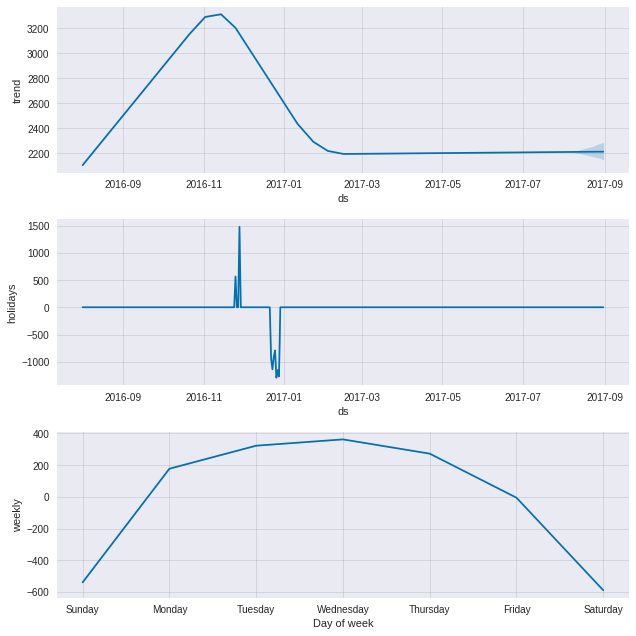

In [16]:
# Show forecast model information
fig2 = m.plot_components(forecast)

## More granular timeseries analysis

### Replicating Anomaly Detection in GA Insights
https://support.google.com/analytics/answer/7507748 

**Hypothesis:** Detecting granular changes in timeseries metrics will give insight into problems or trends otherwise hidden from an analysts view.

The following query generates many timeseries plots that are representative of a combination of dimensions and a single metric. For example, `deviceCategory` + `channelGrouping` + `contentGroup` dimensions each have many unique values (3 devices \* 10 channels \* 10 content groups = 300 unique timeseries keys per metric).  The query will `CONCAT()` those values into a single `key` and generate a timeseries for each metric in the `pairs` object.  

Running each distinct timeseries through the Facebook Prophet library will give us an intelligent forecast model to evaluate future data signals against. As new data comes in,  we can 

In [9]:
%%bigquery timeseries_metrics --project analyticspros.com:spotted-cinnamon-834
WITH
    base AS (
    SELECT
      -- DATETIME_ADD(PARSE_DATETIME('%Y%m%d', date), INTERVAL hits.hour HOUR) as timestamp,
      PARSE_DATETIME('%Y%m%d', date) as timestamp,
      device.deviceCategory as device,
      channelGrouping,
      hits.contentGroup.contentGroup2 as category,
      [ --add your metrics to the array bellow
        STRUCT( "pageviews" AS key, SUM(IF(hits.type = 'PAGE',1,0)) AS value ),
        STRUCT( "transactions" AS key, SUM(IF(hits.transaction.transactionRevenue > 0,1,0) ) AS value ),
        STRUCT( "revenue" AS key, SUM(hits.transaction.transactionRevenue / 1e6) AS value )
      ] AS pairs
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*` , UNNEST(hits) as hits
      group by timestamp, device, channelGrouping, category
    )
  SELECT
    timestamp,
    CONCAT( 
      "device:", device, "|", 
      "channel:", channelGrouping, "|", 
      "category:", category, "|",
      pairs.key 
    ) AS key,
    IFNULL(SUM(pairs.value),0) as value
  FROM
    base,
    UNNEST(base.pairs) AS pairs 
  GROUP BY timestamp, key
  ORDER BY timestamp, value DESC

,timestamp,key,value
0,2016-08-01,device:desktop|channel:Referral|category:(not ...,3562.69
1,2016-08-01,device:desktop|channel:Direct|category:(not se...,2286.15
2,2016-08-01,device:desktop|channel:Referral|category:(not ...,1120.00
3,2016-08-01,device:desktop|channel:Direct|category:(not se...,1028.00
4,2016-08-01,device:desktop|channel:Referral|category:Appar...,722.00
5,2016-08-01,device:desktop|channel:Organic Search|category...,605.00
6,2016-08-01,device:desktop|channel:Organic Search|category...,490.00
7,2016-08-01,device:desktop|channel:Social|category:(not se...,473.00
8,2016-08-01,device:mobile|channel:Direct|category:(not set...,471.00
9,2016-08-01,device:desktop|channel:Organic Search|category...,415.23


### Filter Timeseries to find examples with many data-points:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133209 entries, 0 to 133208
Data columns (total 4 columns):
key          133209 non-null object
timestamp    133209 non-null datetime64[ns]
value        133209 non-null float64
freq         133209 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.1+ MB
device:desktop|channel:Affiliates|category:(not set)|pageviews


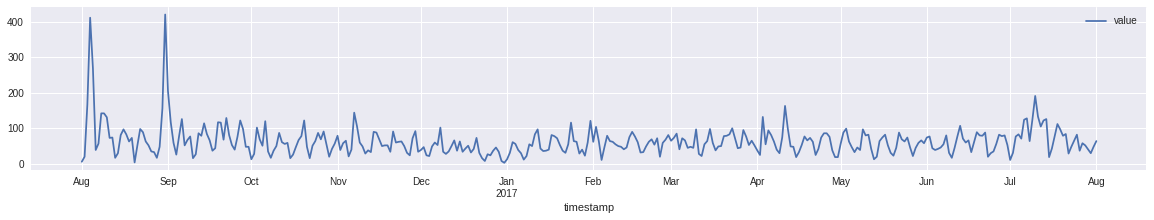

device:desktop|channel:Affiliates|category:(not set)|revenue


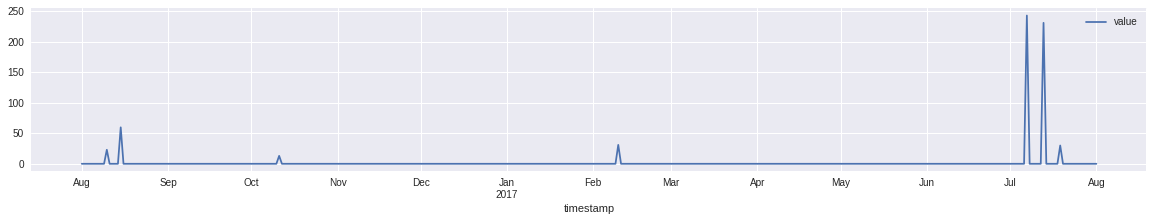

device:desktop|channel:Affiliates|category:(not set)|transactions


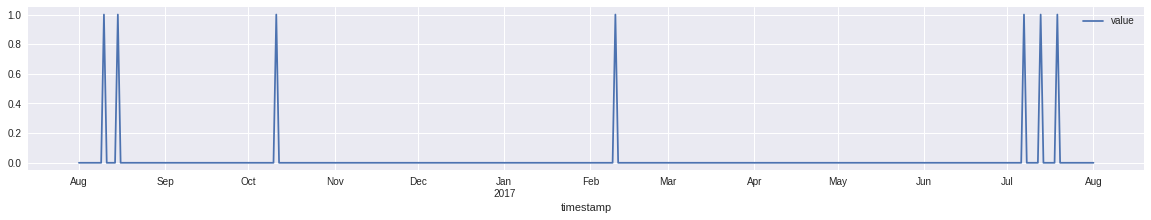

device:desktop|channel:Direct|category:(not set)|pageviews


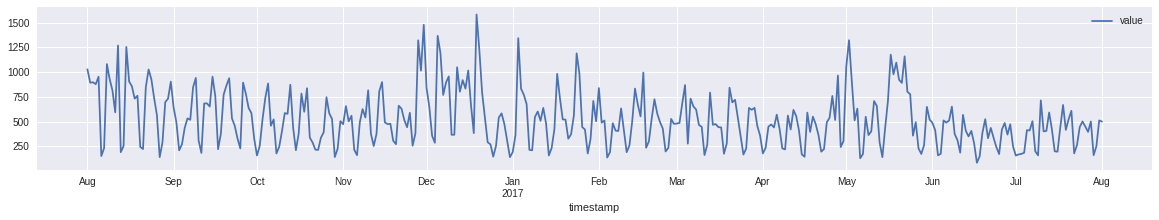

In [10]:
import matplotlib.pyplot as plt

freq = timeseries_metrics.groupby('key').agg({'key': 'count'}).rename(columns={'key': 'freq'}).reset_index()
timeseries_metrics = timeseries_metrics.set_index('key').join(freq.set_index('key')).fillna(0)
timeseries_metrics.reset_index(inplace=True)
timeseries_metrics.info()

target_keys = timeseries_metrics.loc[timeseries_metrics.freq == timeseries_metrics.freq.max()].key.unique()
for target in range(4):
  print (target_keys[target])
  _ = timeseries_metrics[timeseries_metrics.key == target_keys[target]].plot(kind='line',x='timestamp',y='value',figsize=(20,3))
  plt.show()

### Take first Timeseries result and process using FB Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


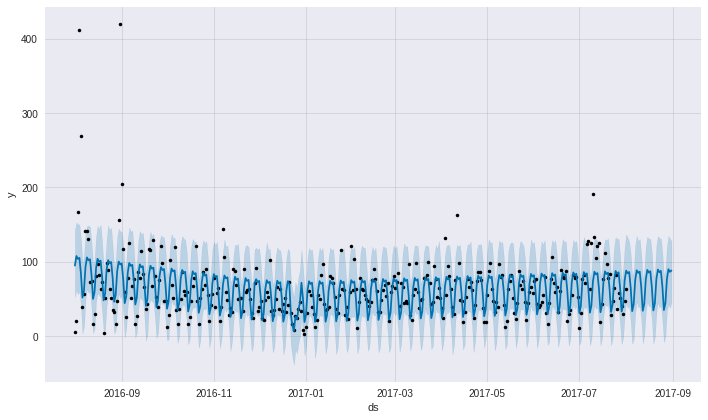

In [39]:
df = timeseries_metrics[timeseries_metrics.key == target_keys[0]][['timestamp', 'value']]
df = df.rename(columns={'timestamp': 'ds', 'value': 'y'})

m = Prophet(holidays=holidays)
m.fit(df)

# Make a prediction for 30 days into the future
f = m.make_future_dataframe(30)
forecast = m.predict(f)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot the model and forecast with additional trend analysis
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)

## Next Steps

1.   Persist dimensional timeseries forecasts to BQ
2.   Evaluate new data against the forecast,  alert when deviations occur
3.   Group multiple deviations together to gain further insight into root cause of shifts in behavior

